# NOTEARS On Medical Datasets and Synthetic Data

In [ ]:
!apt install libgraphviz-dev
!pip install pygraphviz

In [2]:
pip install causalnex

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 154 kB 6.1 MB/s 
     |████████████████████████████████| 27.2 MB 2.1 MB/s 
     |████████████████████████████████| 24.9 MB 72.1 MB/s 
     |████████████████████████████████| 76 kB 3.6 MB/s 
     |████████████████████████████████| 1.9 MB 43.1 MB/s 
     |████████████████████████████████| 132 kB 45.7 MB/s 
     |████████████████████████████████| 52 kB 851 kB/s 
  Created wheel for wrapt: filename=wrapt-1.12.1-cp38-cp38-linux_x86_64.whl size=72345 sha256=4f15fb2a37baedf86b981d377ee6a1d0ea5cafa19e090558e71af6128a4a84bb
  Stored in directory: /root/.cache/pip/wheels/5f/fd/9e/b6cf5890494cb8ef0b5eaff72e5d55a70fb56316007d6dfe73
Successfully built wrapt
  Attempting uninstall: scipy
    Found existing installation: scipy 1.7.3
    Uninstalling scipy-1.7.3:
      Successfully uninstalled scipy-1.7.3
  Attempting uninstall: scikit-learn
    Found existing inst

In [3]:
pip install cdt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 921 kB 7.1 MB/s 
  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7409 sha256=bfa8810190958069718ba04b26a30201c2f3c2161d0b2cdf3f841045d6141d32
  Stored in directory: /root/.cache/pip/wheels/ba/03/bb/7a97840eb54479b328672e15a536e49dc60da200fb21564d53
  Created wheel for skrebate: filename=skrebate-0.62-py3-none-any.whl size=29269 sha256=46e40316891e724dde1ff4e7158e3c9ad3665d89df411f210e3e97e8aaf52127
  Stored in directory: /root/.cache/pip/wheels/1e/93/22/f83048fc1dafedcec44bb4ccf8d08225da96d20115d97a7a77
Successfully built GPUtil skrebate


In [4]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from causalnex.discretiser import Discretiser
from causalnex.structure import DAGRegressor
from causalnex.inference import InferenceEngine
from causalnex.network import BayesianNetwork
from causalnex.network.sklearn import BayesianNetworkClassifier
from causalnex.structure.notears import from_pandas
from causalnex.structure import StructureModel
from causalnex.structure.notears import from_pandas, from_pandas_lasso
from causalnex.discretiser.discretiser_strategy import ( DecisionTreeSupervisedDiscretiserMethod )

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, f1_score, accuracy_score, precision_score

In [86]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler,Normalizer, MinMaxScaler
from cdt.data import AcyclicGraphGenerator

import cdt
import networkx as nx

# Synthetic Data

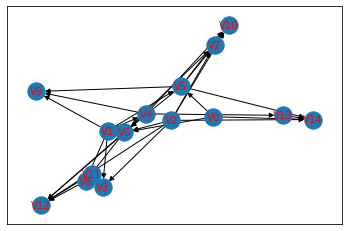

In [6]:
# Seed for reproducibility
import random
random.seed(42)
np.random.seed(42)

# Synthetic data generation
generator = AcyclicGraphGenerator('linear', npoints=5000, nodes=15)
data, graph = generator.generate()
# generator.to_csv('generated_graph')

nx.draw_networkx(graph, font_size=10, font_color='r')

In [134]:
%%time
sm = from_pandas(data)

CPU times: user 3min 24s, sys: 4min 17s, total: 7min 42s
Wall time: 3min 59s


In [21]:
data.head()

,V0,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14
0,-2.568764,0.052102,0.087613,0.049214,0.465514,-1.363929,-2.212298,-1.764103,-0.731039,-0.175724,0.029601,-0.497564,-0.774263,0.352281,-0.516409
1,-2.070301,-0.434261,0.211518,-0.456176,-0.522195,-1.731107,-1.979782,-1.678982,-1.419459,-0.947585,-1.301955,-1.298976,-1.718602,-1.061819,-1.686124
2,-1.864907,0.467301,-0.193652,0.296272,-0.027920,-1.167379,-1.810574,-1.375560,-0.909771,-0.288060,-0.254343,-0.291291,-0.633416,-0.247259,-0.926802
3,-2.261666,-1.183239,-0.368284,-1.281482,-1.401440,-2.243063,-2.554604,-2.467916,-2.122292,-1.629223,-2.255601,-0.495230,-2.372616,-1.238172,-2.083179
4,-0.915521,-0.271413,0.205001,-0.168963,-0.864685,-0.759557,-0.768120,-0.657096,-0.637545,-0.760754,-1.060583,-0.886371,-1.380048,-0.625726,-0.826193


In [135]:

sm_save = sm

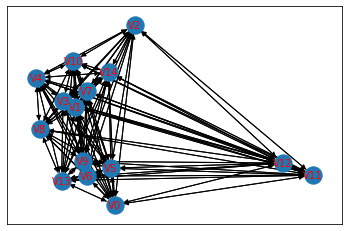

In [136]:
nx.draw_networkx(sm_save, font_size=10, font_color='r')

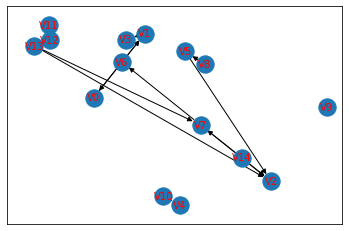

In [137]:
sm_save.remove_edges_below_threshold(0.7)
nx.draw_networkx(sm_save, font_size=10, font_color='r')

In [138]:
# exported to obtain SID on R 
nx.write_gpickle(sm_save, "notears1.gpickle")

In [25]:
shd = cdt.metrics.SHD(graph, sm_save)

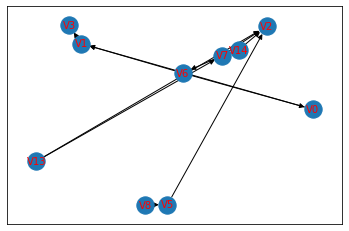

In [26]:
# Bayesian network can be trained only on a dag
sm_save = sm_save.get_largest_subgraph()
nx.draw_networkx(sm_save, font_size=10, font_color='r')

In [27]:
tree_discretiser = DecisionTreeSupervisedDiscretiserMethod(
    mode='single',
    tree_params={'max_depth': 3, 'random_state': 27},
)
tree_discretiser.fit(
    feat_names= data.columns,
    dataframe=data,
    target_continuous=True,
    target="V14"

)
tree_discretiser

DecisionTreeSupervisedDiscretiserMethod(tree_params={'max_depth': 3,
                                                     'random_state': 27})

In [28]:
discretised_data = data.copy()
# discretised_data['age'] = discretised_data['age'].astype(int)
for col in data.columns:
    discretised_data[col] = tree_discretiser.transform(data[[col]])
discretised_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 15 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   V0      5000 non-null   int64
 1   V1      5000 non-null   int64
 2   V2      5000 non-null   int64
 3   V3      5000 non-null   int64
 4   V4      5000 non-null   int64
 5   V5      5000 non-null   int64
 6   V6      5000 non-null   int64
 7   V7      5000 non-null   int64
 8   V8      5000 non-null   int64
 9   V9      5000 non-null   int64
 10  V10     5000 non-null   int64
 11  V11     5000 non-null   int64
 12  V12     5000 non-null   int64
 13  V13     5000 non-null   int64
 14  V14     5000 non-null   int64
dtypes: int64(15)
memory usage: 586.1 KB


In [29]:
train, test = train_test_split( discretised_data, train_size=0.8, test_size=0.2, random_state=27)
bn = BayesianNetwork(sm_save)
bn = bn.fit_node_states(discretised_data)
bn = bn.fit_cpds(train, method="BayesianEstimator", bayes_prior="K2")

BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [30]:
pd.DataFrame(list(sm_save.edges(data='weight')))

,0,1,2
0,V0,V1,-1.420649
1,V1,V3,0.906507
2,V5,V2,-1.801343
3,V6,V0,0.890878
4,V6,V1,1.428790
5,V7,V2,0.864699
6,V7,V6,0.700119
7,V8,V5,0.748509
8,V13,V2,-1.872703
9,V13,V7,-0.927332


In [60]:
from causalnex.evaluation import roc_auc
roc, auc = roc_auc(bn, test, 'V2')

print(f"Structural hamming distance: {shd}")
print(f"Area under the curve: {auc:.3f}")

Structural hamming distance: 44
Area under the curve: 0.932


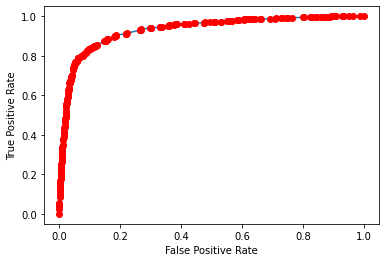

In [61]:
fpr = [x[0] for x in roc]
tpr = [x[1] for x in roc]

plt.plot(fpr,tpr)
plt.plot(fpr,tpr,'or')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

# Cardio Dataset

In [33]:
!git clone https://github.com/Gio99c/Causal-Discovery-Algorithms-on-Medical-Data.git

Cloning into 'Causal-Discovery-Algorithms-on-Medical-Data'...
remote: Enumerating objects: 109, done.
remote: Counting objects: 100% (109/109), done.
remote: Compressing objects: 100% (90/90), done.
remote: Total 109 (delta 41), reused 64 (delta 16), pack-reused 0
Receiving objects: 100% (109/109), 31.42 MiB | 10.81 MiB/s, done.
Resolving deltas: 100% (41/41), done.


In [34]:
cardio_df = pd.read_csv("/content/Causal-Discovery-Algorithms-on-Medical-Data/datasets/cardio.csv", delimiter=";", index_col='id')
cardio_df.head(5)

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [35]:
cardio_df1 =  cardio_df
cardio_df1

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
99993,19240,2,168,76.0,120,80,1,1,1,0,1,0
99995,22601,1,158,126.0,140,90,2,2,0,0,1,1
99996,19066,2,183,105.0,180,90,3,1,0,1,0,1


In [36]:
scaler = StandardScaler()
cardio_df1 = pd.DataFrame(scaler.fit_transform(cardio_df1.to_numpy()), columns=cardio_df1.columns)

In [121]:
%%time
sm_c = from_pandas(cardio_df1, tabu_parent_nodes=['cardio'],)

CPU times: user 50.1 s, sys: 50.6 s, total: 1min 40s
Wall time: 57.7 s


In [122]:
sm_c.remove_edges_below_threshold(0.1)

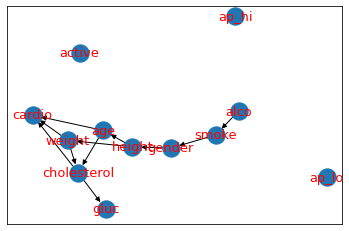

In [123]:
nx.draw_networkx(sm_c, font_size=13, font_color='r',)

In [124]:
sm_c

In [125]:
pd.DataFrame(list(sm_c.edges(data='weight')), columns=['Cause', 'Effect', 'Score']).sort_values(ascending=False,by="Score")

,Cause,Effect,Score
2,gender,height,0.490332
7,cholesterol,gluc,0.440667
10,alco,smoke,0.338317
9,smoke,gender,0.317492
4,height,weight,0.282071
1,age,cardio,0.199382
8,cholesterol,cardio,0.179206
5,weight,cholesterol,0.156258
6,weight,cardio,0.154366
0,age,cholesterol,0.140424


# Breast Cancer Dataset

In [40]:
breast_cancer_df = pd.read_csv("/content/Causal-Discovery-Algorithms-on-Medical-Data/datasets/breast_cancer.csv")
# df = pd.read_csv("/content/Causal-Discovery-Algorithms-on-Medical-Data/datasets/thyroid.csv")
breast_cancer_df.head(5)

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [41]:
# Convert column "diagnosis" from categorical to binary
breast_cancer_df.loc[breast_cancer_df['diagnosis'] == "M", 'diagnosis'] = 1.0
breast_cancer_df.loc[breast_cancer_df['diagnosis'] == "B", 'diagnosis'] = 0.0

# Drop colum "Unnamed: 32" (contains only nan values)
breast_cancer_df.drop(columns=["Unnamed: 32", 'id'], inplace=True)
#target_bc = breast_cancer_df.pop('diagnosis').to_numpy().astype(int)

In [42]:
corr_df = pd.DataFrame(scaler.fit_transform(breast_cancer_df.to_numpy()), columns=breast_cancer_df.columns)
corr_df = pd.DataFrame(corr_df.iloc[:,1:].corrwith(corr_df['diagnosis'])).sort_values(by=0, ascending=False)
corr_df.T

,concave points_worst,perimeter_worst,concave points_mean,radius_worst,perimeter_mean,area_worst,radius_mean,area_mean,concavity_mean,concavity_worst,...,smoothness_mean,symmetry_mean,fractal_dimension_worst,compactness_se,concavity_se,fractal_dimension_se,symmetry_se,texture_se,fractal_dimension_mean,smoothness_se
0,0.793566,0.782914,0.776614,0.776454,0.742636,0.733825,0.730029,0.708984,0.69636,0.65961,...,0.35856,0.330499,0.323872,0.292999,0.25373,0.077972,-0.006522,-0.008303,-0.012838,-0.067016


In [43]:
scaler = Normalizer()
# diagnosis = breast_cancer_df["diagnosis"]
breast_cancer_df1 = breast_cancer_df.iloc[:,1:]
breast_cancer_df1 = pd.DataFrame(scaler.fit_transform(breast_cancer_df1.to_numpy()), columns=breast_cancer_df1.columns)

In [44]:
breast_cancer_df1 = breast_cancer_df1[list(corr_df.T.columns)].iloc[:, :10]

In [45]:
breast_cancer_df1.insert(loc=0, column='diagnosis', value=breast_cancer_df['diagnosis'])
breast_cancer_df1

,diagnosis,concave points_worst,perimeter_worst,concave points_mean,radius_worst,perimeter_mean,area_worst,radius_mean,area_mean,concavity_mean,concavity_worst
0,1.0,2.296076,2.303601,2.532475,1.886690,1.269934,2.001237,1.097064,0.984375,2.652874,2.109526
1,1.0,1.087084,1.535126,0.548144,1.805927,1.685955,1.890489,1.829821,1.908708,-0.023846,-0.146749
2,1.0,1.955000,1.347475,2.037231,1.511870,1.566503,1.456285,1.579888,1.558884,1.363478,0.854974
3,1.0,2.175786,-0.249939,1.451707,-0.281464,-0.592687,-0.550021,-0.768909,-0.764464,1.915897,1.989588
4,1.0,0.729259,1.338539,1.428493,1.298575,1.776573,1.220724,1.750297,1.826229,1.371011,0.613179
...,...,...,...,...,...,...,...,...,...,...,...
564,1.0,1.629151,1.752563,2.320965,1.901185,2.060786,2.015301,2.110995,2.343856,1.947285,0.664512
565,1.0,0.733827,1.421940,1.263669,1.536720,1.615931,1.494959,1.704854,1.723842,0.693043,0.236573
566,1.0,0.414069,0.579001,0.105777,0.561361,0.672676,0.427906,0.702284,0.577953,0.046588,0.326767
567,1.0,2.289985,2.303601,2.658866,1.961239,1.982524,1.653171,1.838341,1.735218,3.296944,3.197605


In [58]:
breast_cancer_df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   diagnosis             569 non-null    object 
 1   concave points_worst  569 non-null    float64
 2   perimeter_worst       569 non-null    float64
 3   concave points_mean   569 non-null    float64
 4   radius_worst          569 non-null    float64
 5   perimeter_mean        569 non-null    float64
 6   area_worst            569 non-null    float64
 7   radius_mean           569 non-null    float64
 8   area_mean             569 non-null    float64
 9   concavity_mean        569 non-null    float64
 10  concavity_worst       569 non-null    float64
dtypes: float64(10), object(1)
memory usage: 49.0+ KB


In [79]:
breast_cancer_df1['diagnosis'] = breast_cancer_df1['diagnosis'].astype(float)

In [80]:
%%time
sm_b = from_pandas(breast_cancer_df1, tabu_parent_nodes=['diagnosis'],)

CPU times: user 33.5 s, sys: 24.4 s, total: 57.9 s
Wall time: 32.1 s


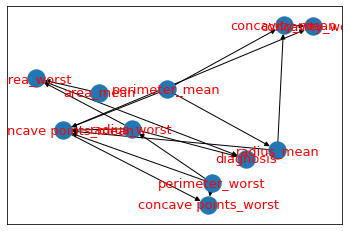

In [81]:
sm_b.remove_edges_below_threshold(0.8)
nx.draw_networkx(sm_b, font_size=13, font_color='r',)

In [126]:
pd.DataFrame(list(sm_b.edges(data='weight')), columns=['Cause', 'Effect', 'Score']).sort_values(ascending=False,by="Score")

,Cause,Effect,Score
8,perimeter_mean,concave points_mean,8.027719
10,perimeter_mean,concavity_mean,4.863425
6,radius_worst,concave points_mean,1.956244
5,radius_worst,diagnosis,1.458629
15,concavity_mean,concavity_worst,1.181915
0,perimeter_worst,concave points_worst,1.013446
2,perimeter_worst,radius_worst,0.986834
7,radius_worst,area_worst,0.954901
14,area_mean,area_worst,0.944806
9,perimeter_mean,radius_mean,0.899699


# Thyroid Dataset

In [63]:
df = pd.read_csv("/content/Causal-Discovery-Algorithms-on-Medical-Data/datasets/thyroid.csv")
df.head(5)

,age,sex,on thyroxine,query on thyroxine,on antithyroid medication,sick,pregnant,thyroid surgery,I131 treatment,query hypothyroid,...,TT4 measured,TT4,T4U measured,T4U,FTI measured,FTI,TBG measured,TBG,referral source,binaryClass
0,41,F,f,f,f,f,f,f,f,f,...,t,125,t,1.14,t,109,f,?,SVHC,P
1,23,F,f,f,f,f,f,f,f,f,...,t,102,f,?,f,?,f,?,other,P
2,46,M,f,f,f,f,f,f,f,f,...,t,109,t,0.91,t,120,f,?,other,P
3,70,F,t,f,f,f,f,f,f,f,...,t,175,f,?,f,?,f,?,other,P
4,70,F,f,f,f,f,f,f,f,f,...,t,61,t,0.87,t,70,f,?,SVI,P


In [64]:
# Binarize textual data
df.replace({'F': 0., 'f': 0., 'M': 1., 't': 1., "P": 1., "N": 0.}, inplace=True)

# Categorical encoding for "referreal source" column
df.replace({'SVHC': 0, 'SVI': 1, 'STMW': 2, 'SVHD': 3, 'other': -1}, inplace=True)

# "?" values have to removed. They cannot be mapped to np.nan because the algorithm won't work. I decided to map those values to 0, but we should discuss this choice
df.replace({'?': 0.}, inplace=True)

# There are no measurements for TBG, can be dropped
df.drop(columns=["TBG", "TBG measured"], inplace=True)

In [65]:
df.rename(columns = {"binaryClass":"diagnosis"},inplace=True)

In [66]:
features = df.iloc[:, :27]
features

,age,sex,on thyroxine,query on thyroxine,on antithyroid medication,sick,pregnant,thyroid surgery,I131 treatment,query hypothyroid,...,TSH,T3 measured,T3,TT4 measured,TT4,T4U measured,T4U,FTI measured,FTI,referral source
0,41,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.3,1.0,2.5,1.0,125,1.0,1.14,1.0,109,0
1,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.1,1.0,2,1.0,102,0.0,0.0,0.0,0.0,-1
2,46,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.98,0.0,0.0,1.0,109,1.0,0.91,1.0,120,-1
3,70,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.16,1.0,1.9,1.0,175,0.0,0.0,0.0,0.0,-1
4,70,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.72,1.0,1.2,1.0,61,1.0,0.87,1.0,70,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3767,30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1
3768,68,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,1.0,2.1,1.0,124,1.0,1.08,1.0,114,1
3769,74,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.1,1.0,1.8,1.0,112,1.0,1.07,1.0,105,-1
3770,72,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.7,1.0,2,1.0,82,1.0,0.94,1.0,87,1


In [105]:
scaler = Normalizer()
minmax_scaler = MinMaxScaler()
features1 = pd.DataFrame(minmax_scaler.fit_transform(features.to_numpy()), columns=features.columns)
thyroid_df = pd.DataFrame(scaler.fit_transform(features1.to_numpy()), columns=features1.columns)

In [106]:
thyroid_df.insert(loc=0, column='diagnosis', value=df['diagnosis'])
thyroid_df

,diagnosis,age,sex,on thyroxine,query on thyroxine,on antithyroid medication,sick,pregnant,thyroid surgery,I131 treatment,...,TSH,T3 measured,T3,TT4 measured,TT4,T4U measured,T4U,FTI measured,FTI,referral source
0,1.0,0.038324,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.001043,0.425306,0.100308,0.425306,0.123636,0.425306,0.208987,0.425306,0.117363,0.106327
1,1.0,0.028736,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.004398,0.568468,0.107258,0.568468,0.134846,0.000000,0.000000,0.000000,0.000000,0.000000
2,1.0,0.043829,0.433529,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000802,0.000000,0.000000,0.433529,0.109895,0.433529,0.170048,0.433529,0.131705,0.000000
3,1.0,0.074878,0.000000,0.48671,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000147,0.486710,0.087240,0.486710,0.198080,0.000000,0.000000,0.000000,0.000000,0.000000
4,1.0,0.065728,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000580,0.427232,0.048366,0.427232,0.060607,0.427232,0.160212,0.427232,0.075712,0.213616
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3767,1.0,0.065791,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3768,1.0,0.062627,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000791,0.419047,0.083019,0.419047,0.120841,0.419047,0.195074,0.419047,0.120940,0.209524
3769,1.0,0.064255,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.003802,0.395081,0.067089,0.395081,0.102905,0.395081,0.182214,0.395081,0.105022,0.000000
3770,1.0,0.061785,0.390444,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000516,0.390444,0.073669,0.390444,0.074457,0.390444,0.158197,0.390444,0.085996,0.195222


In [107]:
newdf = thyroid_df.iloc[:, :18]

In [108]:
newdf

,diagnosis,age,sex,on thyroxine,query on thyroxine,on antithyroid medication,sick,pregnant,thyroid surgery,I131 treatment,query hypothyroid,query hyperthyroid,lithium,goitre,tumor,hypopituitary,psych,TSH measured
0,1.0,0.038324,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.425306
1,1.0,0.028736,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.568468
2,1.0,0.043829,0.433529,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.433529
3,1.0,0.074878,0.000000,0.48671,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.486710
4,1.0,0.065728,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.427232
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3767,1.0,0.065791,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.997833,0.0,0.0,0.000000
3768,1.0,0.062627,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.419047
3769,1.0,0.064255,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.395081,0.0,0.0,0.000000,0.0,0.0,0.395081
3770,1.0,0.061785,0.390444,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.390444


In [113]:
%%time
sm_t = from_pandas(newdf, tabu_parent_nodes=['diagnosis'],)

CPU times: user 4.55 s, sys: 5.83 s, total: 10.4 s
Wall time: 5.51 s


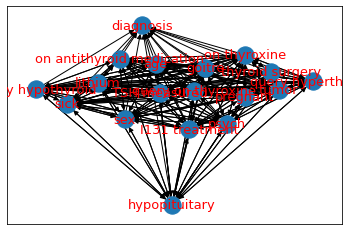

In [114]:
nx.draw_networkx(sm_t, font_size=13, font_color='r',)

In [ ]:
sm_t.remove_edges_below_threshold(0.8)
# nx.draw_networkx(sm_t, font_size=10, font_color='r',)

In [117]:
sm_t = sm_t.get_largest_subgraph()

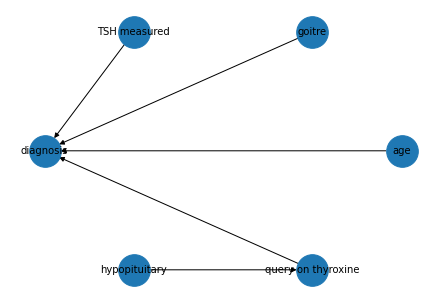

In [118]:
nx.draw_shell(sm_t, font_size=10,node_size=1000 ,with_labels=True)

In [127]:
pd.DataFrame(list(sm_t.edges(data='weight')), columns=['Cause', 'Effect', 'Score']).sort_values(ascending=False,by="Score")

,Cause,Effect,Score
4,TSH measured,diagnosis,1.726372
2,age,diagnosis,1.083871
0,hypopituitary,query on thyroxine,0.949654
1,query on thyroxine,diagnosis,0.866448
3,goitre,diagnosis,0.862113
